# Experimental Learning
Experiment with OpenAI embeddings using Langchain document loader and different splitter and splitting strategies, visualize the embeddings, and document the findings in order to which to use and when.

## Install necessary libraries

Install `openai`, `langchain`, and other necessary libraries.


**Reasoning**:
Install the necessary libraries using pip.



In [1]:
%pip install openai langchain matplotlib scikit-learn
%pip install -U langchain-community
%pip install -qU pypdf

## Load and process a document

Use a Langchain document loader to load with moving on creating various splitters to split it into chunks and test different splitting techniques.


In [2]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os
from langchain_community.document_loaders import PyPDFLoader

file_path = "/content/documents/test_ncert.pdf"

# Use PyPDFLoader to load the PDF document
loader = PyPDFLoader(file_path)

# Load the pages from the PDF
pages = loader.load()
#A benifit of using pyPDFLoader is we get additional data(page_label) as key values, as metadata, which can be beneficial to build your logic around.

pages = []
async for page in loader.alazy_load():
    pages.append(page)
# stored all the page's extracted in pages array and try check it out for yourself, making sure without going out of bounds.
# print(pages[3:8])

# Now, 'pages' is a list of Document objects, one for each page of the PDF.
# We can treat these pages as the 'documents' for splitting.
documents = pages
print(f"Number of pages loaded from document: {len(documents)}")


Number of pages loaded from document: 114


**How to decide the chunk size ?, Hear me out...**

Getting the average *character* count for each page, from the complete document loaded above -> It can give closer idea what to capture in a single page, can be tweaked further

In [3]:
char_counts = [len(doc.page_content) for doc in documents]
total_pages = len(documents)
avg_chars_per_page = sum(char_counts) / total_pages if total_pages > 0 else 0
print(f"Average characters per page: {avg_chars_per_page:.2f}")

# Estimate token count for token-based splitters (approx. 4.5 chars/token for English)
avg_tokens_per_page = int(avg_chars_per_page / 4.5)
print(f"Estimated average tokens per page: {avg_tokens_per_page}")

Average characters per page: 2062.25
Estimated average tokens per page: 458


# Creating Splitters.

1. **Length-based**

* The most intuitive strategy is to split documents based on their length. This simple yet effective approach ensures that each chunk doesn't exceed a specified size limit.


*   Types of length-based splitting:

 * **Token-based**: Splits directly based on token counts using a tokenizer (e.g., tiktoken). Unlike CharacterTextSplitter, it doesn't rely on character-based separators; it purely uses token boundaries, making it ideal for LLM compatibility.
 * **Character-based**: Splits text based on a fixed number of characters, using a specified separator (e.g., "\n\n"). If the separator isn't found, it may split arbitrarily or return oversized chunks. It's simple and length-based, ignoring semantic structure unless wrapped with token-based measurement
```
encoding_name="cl100k_base": Uses OpenAI's token encoder for chunk sizing.
chunk_size=100: Max 100 tokens per chunk.
chunk_overlap=0: No overlapping tokens. (for contextual overlap between documents)
separator (default "\n\n"): Split point (can be overridden).
```

2. **NLTK Text Splitter**
* Uses NLTK's sentence tokenizer (punkt) to split text into sentences, then groups them into chunks based on a specified chunk_size (in characters by default). It respects sentence boundaries, making it more semantically aware than character/token splitters.

3. **Sentence Transformer Token Splitter**
* Splits text based on tokens defined by a Sentence Transformers model (e.g., sentence-transformers/all-MiniLM-L6-v2), ensuring chunks fit within a model's token limit (e.g., 256 tokens for MiniLM). It tokenizes text using the model's tokenizer, making it ideal for embedding tasks.

4. **Spacy Text Splitter**
* Uses SpaCy's sentence segmentation to split text into sentences, then groups into chunks based on character count. Similar to NLTKTextSplitter but leverages SpaCy's advanced NLP pipeline for more accurate sentence detection, especially for complex or multilingual text.





In [4]:
from langchain_text_splitters import CharacterTextSplitter
from langchain_text_splitters import TokenTextSplitter
from langchain_text_splitters import NLTKTextSplitter
from langchain_text_splitters import SentenceTransformersTokenTextSplitter
from langchain_text_splitters import SpacyTextSplitter
import nltk
# nltk.download('punkt_tab')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import pandas as pd

# Collect per-chunk length data for each method
splitter_results = []

def collect_chunk_data(strategy_name, chunks):
    lengths = [len(chunk.page_content) for chunk in chunks]
    for l in lengths:
        splitter_results.append({
            "Splitter": strategy_name,
            "Chunk Length": l
        })

# Replace your print_chunk_info calls with collect_chunk_data calls after splitting
chunks_sizes = []
splitter_names = []

def print_chunk_info(strategy_name, chunks, separator_info="No separator"):
    print(f"\n--- {strategy_name} Splitting ---")
    print(f"Separator: {separator_info}")
    print(f"Number of chunks: {len(chunks)}")
    chunks_sizes.append(len(chunks))
    splitter_names.append(strategy_name)
    collect_chunk_data(strategy_name, chunks)
    for i, chunk in enumerate(chunks[:3]):
        print(f"Chunk {i+1}: {chunk.page_content[:200]}...")
        print("---")

# 1. Character Splitter - 113 Chunks on 100 chunk_size
char_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base",
    chunk_size=256,
    chunk_overlap=128,
    separator="\n\n"  # Try to respect paragraph breaks
)

char_chunks = char_splitter.split_documents(documents)
print_chunk_info("CharacterTextSplitter (tiktoken)", char_chunks)

# 2. TokenTextSplitter - 911 Chunks on 100 chunk_size
token_splitter = TokenTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base",
    chunk_size=256,
    chunk_overlap=128,
)
token_chunks = token_splitter.split_documents(documents)
print_chunk_info("TokenTextSplitter", token_chunks)

# # 3. NLTKTextSplitter - 2151 Chunks on 100 chunk_size
nltk_splitter = NLTKTextSplitter(
    chunk_size=256,  # Characters, not tokens
    chunk_overlap=128,
    separator="\n"  # Join sentences with newline
)
nltk_chunks = nltk_splitter.split_documents(documents)
print_chunk_info("NLTKTextSplitter", nltk_chunks)

# # 4. SentenceTransformersTokenTextSplitter - 687 Chunks on 100 chunk_size
st_splitter = SentenceTransformersTokenTextSplitter(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    tokens_per_chunk=256,
    chunk_overlap=128
)
st_chunks = st_splitter.split_documents(documents)
print_chunk_info("SentenceTransformersTokenTextSplitter", st_chunks)

# # 5. SpacyTextSplitter - 2245 Chunks on 100 chunk_size
spacy_splitter = SpacyTextSplitter(
    pipeline="en_core_web_sm",
    chunk_size=256,  # Characters
    chunk_overlap=128
)
spacy_chunks = spacy_splitter.split_documents(documents)
print_chunk_info("SpacyTextSplitter", spacy_chunks)


print(chunks_sizes)


--- CharacterTextSplitter (tiktoken) Splitting ---
Separator: No separator
Number of chunks: 113
Chunk 1: Contents
Foreword iii
A Letter for You v
Unit I
Chapter 1
Power sharing 1
Chapter 2
Federalism 13
Unit II
Chapter 3
Democracy and Diversity 29
Chapter 4
Gender, Religion and Caste 39
Unit III
Chapter ...
---
Chunk 2: P
♦
 
✁
✂
✄
❤
☎
✂
✆
✝
✞
1
❈
✟
✠
✡
☛
☞
✌
✍
❖ ✎ ❡ ✏ ✎ ✑❡ ✒
❲ ✓ ✔ ✕ ✔ ✕ ✓ s ✖ ✕ ✗ ✘ ✔ ✙ ✚ ✛ ✙ ✚ ✙ s ✜ ✢ ✙ ✔ ✕ ✙ ✔ ✣ ✜ ✚ ✣ ✤ ✥ ✙ ✢ ✣ ✖ ✚ ✗ ✖❛ ✔ ✕ ✗ ✔ ✛ ✙ s ✔ ✗ ✚ ✔ ✙ ✥
❧
✗ s ✔ ❛ ✙ ✗ ✚
✳
❲ ✙
✦
✣ ✔ ✙ ✥
❧
✗ ...
---
Chunk 3: 2
❉
 
✁
✂
✄
☎
❛
✆
✝
✄
✞
✂
♦
✝
✆
✝
✄
✟
❇ ✠ ✡ ☛ ☞ ✌ ✍ ✎ ✏ ✑ ✒ ✓ ☞ ✔ ✎ ✏ ✕ ✎
I have a simple
equation in mind.
Sharing power =
dividing power =
weakening the
country. Why do we
start by talking of
this?
...
---

--- TokenTextSplitter Splitting ---
Separator: No separator
Number of chunks: 492
Chunk 1: Contents
Foreword iii
A Letter for You v
Unit I
Chapter 1
Power sharing 1
Chapter 2
Federalism 13
Unit II
Chapter 3
Democracy and Diversity 29
Chapter 4
Gender


--- NLTKTextSplitter Splitting ---
Separator: No separator
Number of chunks: 1449
Chunk 1: Contents
Foreword iii
A Letter for You v
Unit I
Chapter 1
Power sharing 1
Chapter 2
Federalism 13
Unit II
Chapter 3
Democracy and Diversity 29
Chapter 4
Gender, Religion and Caste 39
Unit III
Chapter ...
---
Chunk 2: P
♦
 
✁
✂
✄
❤
☎
✂
✆
✝
✞
1
❈
✟
✠
✡
☛
☞
✌
✍
❖ ✎ ❡ ✏ ✎ ✑❡ ✒
❲ ✓ ✔ ✕ ✔ ✕ ✓ s ✖ ✕ ✗ ✘ ✔ ✙ ✚ ✛ ✙ ✚ ✙ s ✜ ✢ ✙ ✔ ✕ ✙ ✔ ✣ ✜ ✚ ✣ ✤ ✥ ✙ ✢ ✣ ✖ ✚ ✗ ✖❛ ✔ ✕ ✗ ✔ ✛ ✙ s ✔ ✗ ✚ ✔ ✙ ✥
❧
✗ s ✔ ❛ ✙ ✗ ✚
✳
❲ ✙
✦
✣ ✔ ✙ ✥
❧
✗ ...
---
Chunk 3: 2
❉
 
✁
✂
✄
☎
❛
✆
✝
✄
✞
✂
♦
✝
✆
✝
✄
✟
❇ ✠ ✡ ☛ ☞ ✌ ✍ ✎ ✏ ✑ ✒ ✓ ☞ ✔ ✎ ✏ ✕ ✎
I have a simple
equation in mind.
Sharing power =
dividing power =
weakening the
country.
Why do we
start by talking of
this?
...
---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



--- SentenceTransformersTokenTextSplitter Splitting ---
Separator: No separator
Number of chunks: 360
Chunk 1: contents foreword iii a letter for you v unit i chapter 1 power sharing 1 chapter 2 federalism 13 unit ii chapter 3 democracy and diversity 29 chapter 4 gender, religion and caste 39 unit iii chapter ...
---
Chunk 2: p ♦ [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] 1 [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] s [UNK] ...
---
Chunk 3: [UNK] [UNK] s [UNK] [UNK] [UNK] [UNK] [UNK] s [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] s [UNK] [UNK] [UNK] [UNK] [U...
---


/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)



--- SpacyTextSplitter Splitting ---
Separator: No separator
Number of chunks: 1501
Chunk 1: Contents
Foreword iii
A Letter for You v
Unit I
Chapter 1
Power sharing 1
Chapter 2
Federalism 13
Unit II
Chapter 3
Democracy and Diversity 29
Chapter 4
Gender, Religion and Caste 39
Unit III
Chapter ...
---
Chunk 2: P
♦
 
✁
✂
✄
❤
☎
✂
✆
✝
✞
1
❈
✟
✠
✡
☛
☞
✌
✍
❖ ✎ ❡ ✏ ✎ ✑❡ ✒
❲ ✓ ✔ ✕ ✔ ✕ ✓ s ✖ ✕ ✗ ✘ ✔ ✙ ✚ ✛ ✙ ✚ ✙ s ✜ ✢ ✙ ✔ ✕ ✙ ✔ ✣ ✜ ✚ ✣ ✤ ✥ ✙ ✢ ✣ ✖ ✚ ✗ ✖❛ ✔ ✕ ✗ ✔ ✛ ✙ s ✔ ✗ ✚ ✔ ✙ ✥
❧
✗ s ✔ ❛ ✙ ✗ ✚
✳
❲ ✙
✦
✣ ✔ ✙ ✥
❧
✗ ...
---
Chunk 3: ✙ ✚
✗ ✢ ✣
✦
❣
❧
✙ ❣ ✓ s
❧
✗ ✔ ✜ ✚ ✙
★
✙
✩
✙ ✖ ✜ ✔ ✓
✪
✙ ✗
✦
✥
✫
✜ ✥ ✓ ✖ ✓ ✗ ✚ ❛ ✓ s
✪


✙ ✚ ❛ ✓ ✢ ✘ ✣ ✚ ✔ ✗
✦
✔ ✔ ✣ ✔ ✕ ✙
✥ ✙ s ✓ ❣
✦
✣ ✤ ✗ ✥ ✙ ✢ ✣ ✖ ✚ ✗ ✖❛
✳
✬
✦
✔ ✕ ✓ s ✗
✦
✥ ✔ ✕ ✙
✦
✙
✩
✔ ✔ ✛ ✣ ✖ ✕...
---
[113, 492, 1449, 360, 1501]


# Important Information from above *Worth Noting.*

Separator Info in Output: Added separator_info to print_chunk_info to explicitly show whether each splitter uses a separator:

1. CharacterTextSplitter: Uses "\n\n" to try splitting at paragraphs.
2. TokenTextSplitter: No separator; splits on token count.
3. NLTKTextSplitter: Uses "\n" to join sentences within chunks but splits on sentence boundaries (not a separator in the same sense).
4. SentenceTransformersTokenTextSplitter: No separator; uses model-specific tokenizer.
5. SpacyTextSplitter: No separator; relies on SpaCy’s sentence segmentation.



Bar Chart → Quickly spot “over-splitters” vs “balanced splitters.”

Violin Plot → See which methods create consistent chunk sizes (smooth learning for embeddings) vs. messy.

Overlap Map → Shows visually how chunk lengths vary at the start — you’ll see which is choppier.

Word Clouds → A human-friendly sanity check: does the first chunk make semantic sense?

Radar Chart → Like a sports stats card for each splitter — instantly comparable.


--- CharacterTextSplitter (tiktoken) ---
Separator: No separator
Number of chunks: 113
Chunk 1: Contents
Foreword iii
A Letter for You v
Unit I
Chapter 1
Power sharing 1
Chapter 2
Federalism 13
Un...
---
Chunk 2: P
♦
 
✁
✂
✄
❤
☎
✂
✆
✝
✞
1
❈
✟
✠
✡
☛
☞
✌
✍
❖ ✎ ❡ ✏ ✎ ✑❡ ✒
❲ ✓ ✔ ✕ ✔ ✕ ✓ s ✖ ✕ ✗ ✘ ✔ ✙ ✚ ✛ ✙ ✚ ✙ s ✜ ✢...
---

--- TokenTextSplitter ---
Separator: No separator
Number of chunks: 492
Chunk 1: Contents
Foreword iii
A Letter for You v
Unit I
Chapter 1
Power sharing 1
Chapter 2
Federalism 13
Un...
---
Chunk 2: P
♦
 
✁
✂
✄
❤
☎
✂
✆
✝
✞
1
❈
✟
✠
✡
☛
☞
✌
✍
❖ ✎ ❡ ✏ ✎ ✑❡ ✒
❲ ✓ ✔ ✕ ✔ ✕ ✓ s ✖ ✕ ✗ ✘ ✔ ✙ ✚ ✛ ✙ ✚ ✙ s ✜ ✢...
---



--- NLTKTextSplitter ---
Separator: No separator
Number of chunks: 1449
Chunk 1: Contents
Foreword iii
A Letter for You v
Unit I
Chapter 1
Power sharing 1
Chapter 2
Federalism 13
Un...
---
Chunk 2: P
♦
 
✁
✂
✄
❤
☎
✂
✆
✝
✞
1
❈
✟
✠
✡
☛
☞
✌
✍
❖ ✎ ❡ ✏ ✎ ✑❡ ✒
❲ ✓ ✔ ✕ ✔ ✕ ✓ s ✖ ✕ ✗ ✘ ✔ ✙ ✚ ✛ ✙ ✚ ✙ s ✜ ✢...
---

--- SentenceTransformersTokenTextSplitter ---
Separator: No separator
Number of chunks: 360
Chunk 1: contents foreword iii a letter for you v unit i chapter 1 power sharing 1 chapter 2 federalism 13 un...
---
Chunk 2: p ♦ [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] 1 [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK...
---



--- SpacyTextSplitter ---
Separator: No separator
Number of chunks: 1501
Chunk 1: Contents
Foreword iii
A Letter for You v
Unit I
Chapter 1
Power sharing 1
Chapter 2
Federalism 13
Un...
---
Chunk 2: P
♦
 
✁
✂
✄
❤
☎
✂
✆
✝
✞
1
❈
✟
✠
✡
☛
☞
✌
✍
❖ ✎ ❡ ✏ ✎ ✑❡ ✒
❲ ✓ ✔ ✕ ✔ ✕ ✓ s ✖ ✕ ✗ ✘ ✔ ✙ ✚ ✛ ✙ ✚ ✙ s ✜ ✢...
---


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


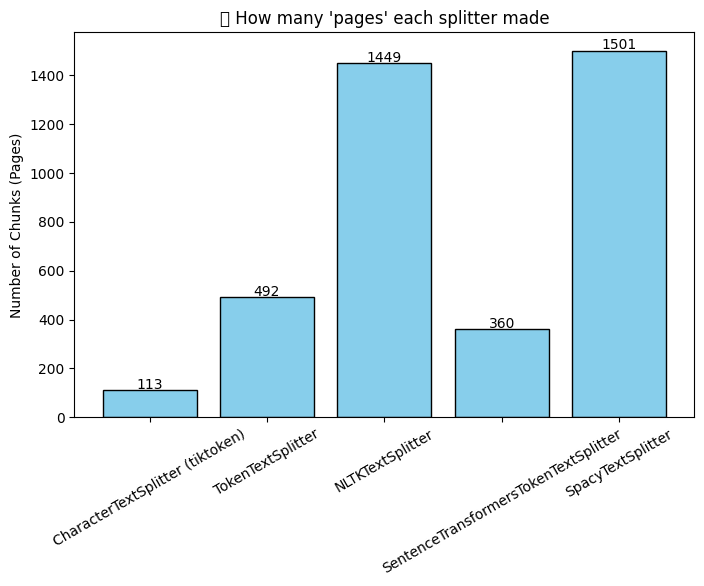

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


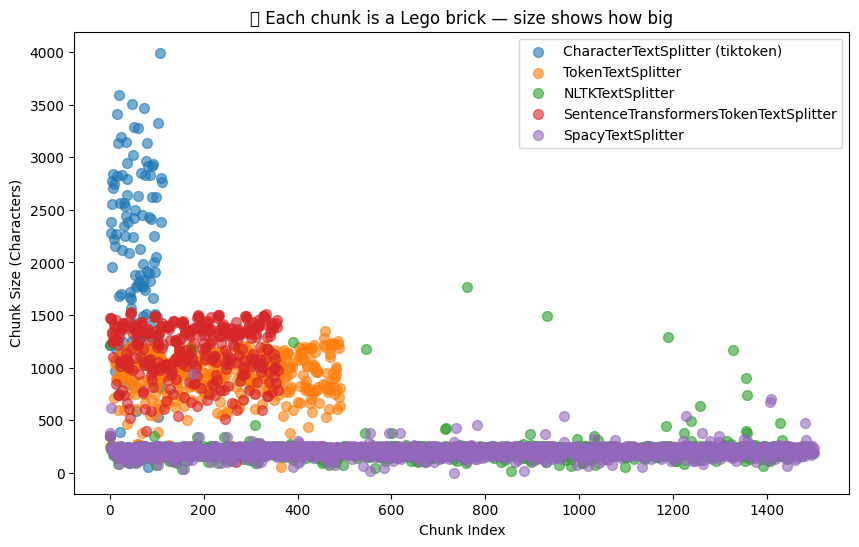

/tmp/ipython-input-1901094139.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129698 (\N{KNOT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


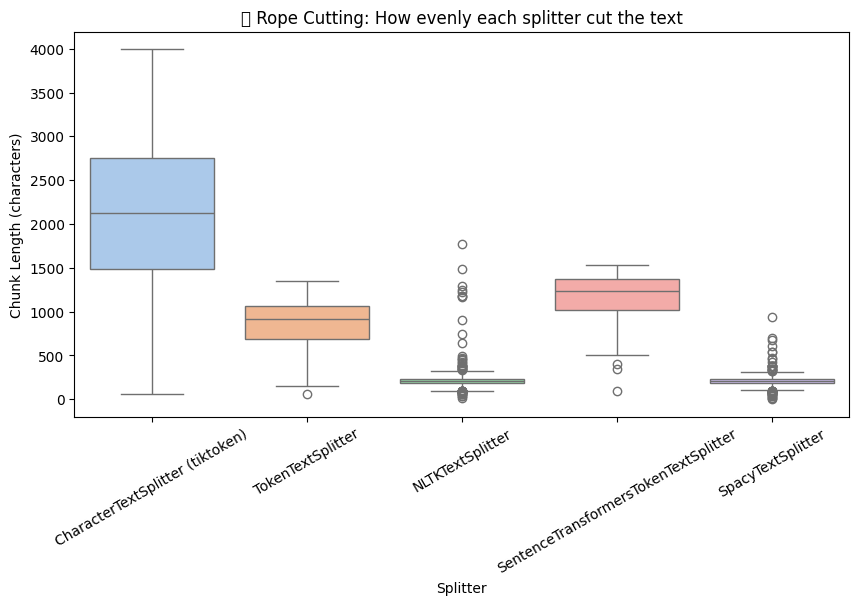

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


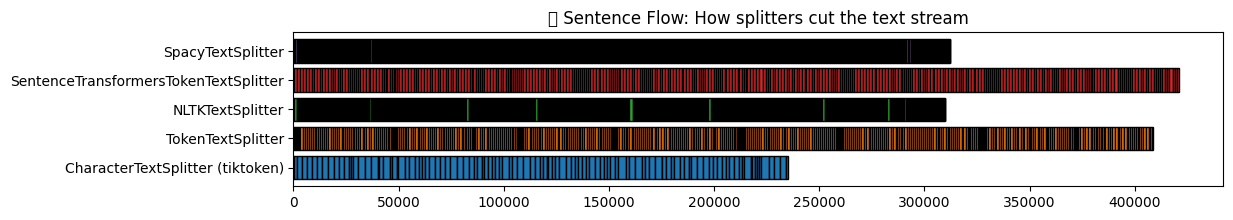

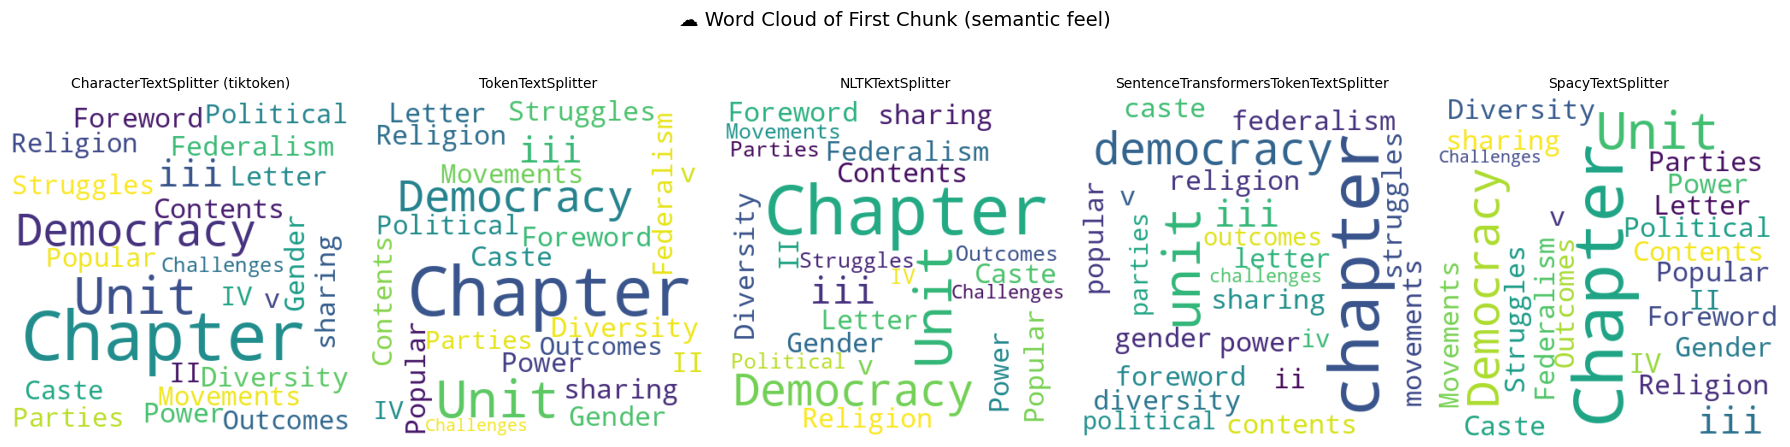

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np

# We'll store chunks with their names for easy reference
splitter_data = {}

def collect_chunk_data(strategy_name, chunks):
    lengths = [len(chunk.page_content) for chunk in chunks]
    splitter_data[strategy_name] = {
        "chunks": chunks,
        "lengths": lengths
    }

def print_chunk_info(strategy_name, chunks, separator_info="No separator"):
    print(f"\n--- {strategy_name} ---")
    print(f"Separator: {separator_info}")
    print(f"Number of chunks: {len(chunks)}")
    collect_chunk_data(strategy_name, chunks)
    for i, chunk in enumerate(chunks[:2]):  # preview
        print(f"Chunk {i+1}: {chunk.page_content[:100]}...")
        print("---")

# After your splitting code runs, you'll have `splitter_data` filled
# 1. Character Splitter - 113 Chunks on 100 chunk_size
char_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base",
    chunk_size=256,
    chunk_overlap=128,
    separator="\n\n"  # Try to respect paragraph breaks
)

char_chunks = char_splitter.split_documents(documents)
print_chunk_info("CharacterTextSplitter (tiktoken)", char_chunks)

# 2. TokenTextSplitter - 911 Chunks on 100 chunk_size
token_splitter = TokenTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base",
    chunk_size=256,
    chunk_overlap=128,
)
token_chunks = token_splitter.split_documents(documents)
print_chunk_info("TokenTextSplitter", token_chunks)

# # 3. NLTKTextSplitter - 2151 Chunks on 100 chunk_size
nltk_splitter = NLTKTextSplitter(
    chunk_size=256,  # Characters, not tokens
    chunk_overlap=128,
    separator="\n"  # Join sentences with newline
)
nltk_chunks = nltk_splitter.split_documents(documents)
print_chunk_info("NLTKTextSplitter", nltk_chunks)

# # 4. SentenceTransformersTokenTextSplitter - 687 Chunks on 100 chunk_size
st_splitter = SentenceTransformersTokenTextSplitter(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    tokens_per_chunk=256,
    chunk_overlap=128
)
st_chunks = st_splitter.split_documents(documents)
print_chunk_info("SentenceTransformersTokenTextSplitter", st_chunks)

# # 5. SpacyTextSplitter - 2245 Chunks on 100 chunk_size
spacy_splitter = SpacyTextSplitter(
    pipeline="en_core_web_sm",
    chunk_size=256,  # Characters
    chunk_overlap=128
)
spacy_chunks = spacy_splitter.split_documents(documents)
print_chunk_info("SpacyTextSplitter", spacy_chunks)



# ----- Visualization 1: Stacks of Paper (Chunk Counts) -----
plt.figure(figsize=(8,5))
counts = {k: len(v["chunks"]) for k,v in splitter_data.items()}
plt.bar(counts.keys(), counts.values(), color="skyblue", edgecolor="black")
plt.ylabel("Number of Chunks (Pages)")
plt.title("📖 How many 'pages' each splitter made")
plt.xticks(rotation=30)
for i, val in enumerate(counts.values()):
    plt.text(i, val+5, str(val), ha='center')
plt.show()

# ----- Visualization 2: Lego Bricks (Chunk Sizes) -----
plt.figure(figsize=(10,6))
for i, (splitter, data) in enumerate(splitter_data.items()):
    plt.scatter(range(len(data["lengths"])), data["lengths"],
                s=50, alpha=0.6, label=splitter)
plt.legend()
plt.xlabel("Chunk Index")
plt.ylabel("Chunk Size (Characters)")
plt.title("🧱 Each chunk is a Lego brick — size shows how big")
plt.show()

# ----- Visualization 3: Rope Cutting (Chunk Size Distribution) -----
plt.figure(figsize=(10,5))

# Create a proper DataFrame for Seaborn
rope_df = pd.DataFrame([
    {"Splitter": splitter, "Chunk Length": length}
    for splitter, data in splitter_data.items()
    for length in data["lengths"]
])

sns.boxplot(
    data=rope_df,
    x="Splitter",
    y="Chunk Length",
    palette="pastel"
)
plt.title("🪢 Rope Cutting: How evenly each splitter cut the text")
plt.xticks(rotation=30)
plt.ylabel("Chunk Length (characters)")
plt.show()


# ----- Visualization 4: Sentence Flow (first 500 chars) -----
sample_text = splitter_data[list(splitter_data.keys())[0]]["chunks"][0].page_content[:500]
start_idx = 0
colors = plt.cm.tab10.colors
plt.figure(figsize=(12,2))
for idx, (splitter, data) in enumerate(splitter_data.items()):
    y = idx
    x = 0
    for chunk in data["chunks"]:
        c_len = len(chunk.page_content)
        plt.barh(y, c_len, left=x, color=colors[idx % len(colors)], edgecolor="black")
        x += c_len
plt.yticks(range(len(splitter_data)), list(splitter_data.keys()))
plt.title("🌊 Sentence Flow: How splitters cut the text stream")
plt.show()

# ----- Visualization 5: Word Cloud (First Chunk) -----
fig, axes = plt.subplots(1, len(splitter_data), figsize=(18,5))
for i, (splitter, data) in enumerate(splitter_data.items()):
    first_chunk_text = data["chunks"][0].page_content
    wc = WordCloud(width=400, height=400, background_color="white").generate(first_chunk_text)
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(splitter, fontsize=10)
plt.suptitle("☁️ Word Cloud of First Chunk (semantic feel)", fontsize=14)
plt.tight_layout()
plt.show()


## Create embeddings

Use OpenAI embeddings to create embeddings for the document chunks.

In [6]:
from langchain.embeddings import OpenAIEmbeddings
import os
from google.colab import userdata


# Instantiate OpenAIEmbeddings
# You need to have your OpenAI API key set up as an environment variable (e.g., OPENAI_API_KEY)
# or pass it directly: embeddings = OpenAIEmbeddings(openai_api_key="YOUR_API_KEY")
# If you don't have an API key, you can use a different embedding model like HuggingFaceEmbeddings

# Ensure you have your OpenAI API key set as an environment variable
# os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY" # Uncomment and replace with your key if not set as environment variable

# Explicitly read the environment variable and pass it to the constructor
openai_api_key = userdata.get('OPENAI_API_KEY')
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key, model="text-embedding-3-small")

# Dictionary to store embeddings for each chunk type
chunk_embeddings = {}

for splitter_name, data in splitter_data.items():
    print(f"\nCreating embeddings for: {splitter_name}")
    chunk_texts = [chunk.page_content for chunk in data["chunks"]]
    embedded = embeddings.embed_documents(chunk_texts)
    chunk_embeddings[splitter_name] = embedded
    # Print summary info
    print(f"First embedding (first 10 dims): {embedded[0][:10]}...")
    print(f"Number of embeddings: {len(embedded)}")
    print(f"Dimension of each embedding: {len(embedded[0])}")

/tmp/ipython-input-2862798468.py:16: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key, model="text-embedding-3-small")



Creating embeddings for: CharacterTextSplitter (tiktoken)
First embedding (first 10 dims): [0.021429987673775856, -0.007529455065696754, 0.05691950286645558, 0.019465288363048592, 0.026211134734360493, 0.017352952084994315, 0.010175553220860356, 0.040656786697385414, -0.005672643878175006, 0.06836699861010911]...
Number of embeddings: 113
Dimension of each embedding: 1536

Creating embeddings for: TokenTextSplitter
First embedding (first 10 dims): [0.021429987673775856, -0.007529455065696754, 0.05691950286645558, 0.019465288363048592, 0.026211134734360493, 0.017352952084994315, 0.010175553220860356, 0.040656786697385414, -0.005672643878175006, 0.06836699861010911]...
Number of embeddings: 492
Dimension of each embedding: 1536

Creating embeddings for: NLTKTextSplitter
First embedding (first 10 dims): [0.021429987673775856, -0.007529455065696754, 0.05691950286645558, 0.019465288363048592, 0.026211134734360493, 0.017352952084994315, 0.010175553220860356, 0.040656786697385414, -0.0056726

In [7]:
import umap
import plotly.express as px
from sklearn.cluster import KMeans

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
umap_points = []
splitter_labels = []
chunk_texts = []
chunk_lengths = []

for splitter, chunks in splitter_data.items():
    emb = chunk_embeddings[splitter]
    umap_emb = umap_model.fit_transform(emb)
    umap_points.extend(umap_emb)
    splitter_labels.extend([splitter]*len(emb))
    chunk_texts.extend([chunk.page_content[:200] for chunk in chunks['chunks']])
    chunk_lengths.extend([len(chunk.page_content) for chunk in chunks['chunks']])

# Clustering
kmeans = KMeans(n_clusters=8, random_state=42).fit(umap_points)
cluster_labels = kmeans.labels_

fig = px.scatter(
    x=[p[0] for p in umap_points], y=[p[1] for p in umap_points],
    color=splitter_labels,
    hover_data={'Chunk Length': chunk_lengths, 'Text': chunk_texts, 'Cluster': cluster_labels},
    title='UMAP 2D Embedding of Chunks by Splitter'
)
fig.show()

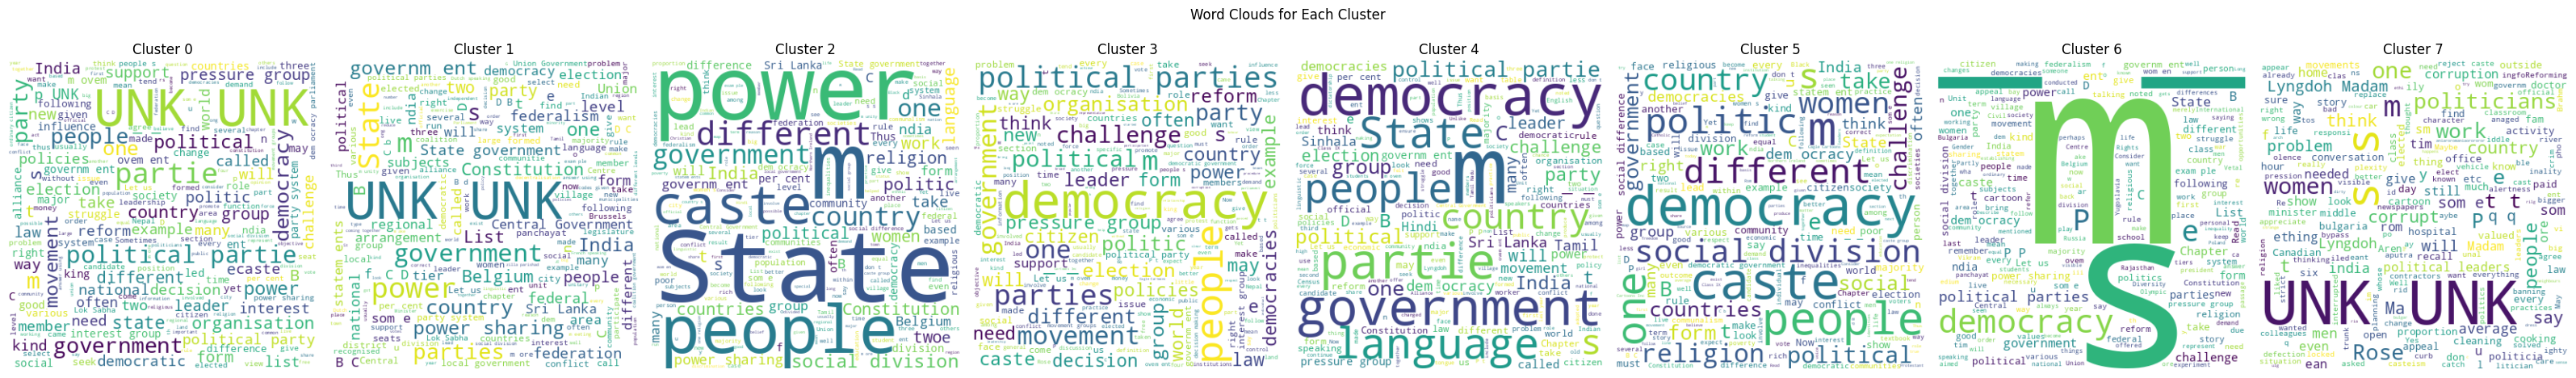

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

num_clusters = max(cluster_labels) + 1
fig, axes = plt.subplots(1, num_clusters, figsize=(4*num_clusters, 5))
for i in range(num_clusters):
    cluster_text = ' '.join([chunk_texts[j] for j in range(len(cluster_labels)) if cluster_labels[j] == i])
    wc = WordCloud(width=400, height=400, background_color="white").generate(cluster_text)
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Cluster {i}")
plt.suptitle("Word Clouds for Each Cluster")
plt.tight_layout()
plt.show()

In [9]:
import plotly.graph_objects as go

for splitter in splitter_data.keys():
    indices = [i for i, s in enumerate(splitter_labels) if s == splitter]
    splitter_clusters = [cluster_labels[i] for i in indices]
    fig = go.Figure(go.Sankey(
        node=dict(label=[f"Cluster {i}" for i in range(num_clusters)]),
        link=dict(
            source=splitter_clusters[:-1],
            target=splitter_clusters[1:],
            value=[1]* (len(splitter_clusters)-1)
        )
    ))
    fig.update_layout(title_text=f"Topic Flow for {splitter}", font_size=10)
    fig.show()

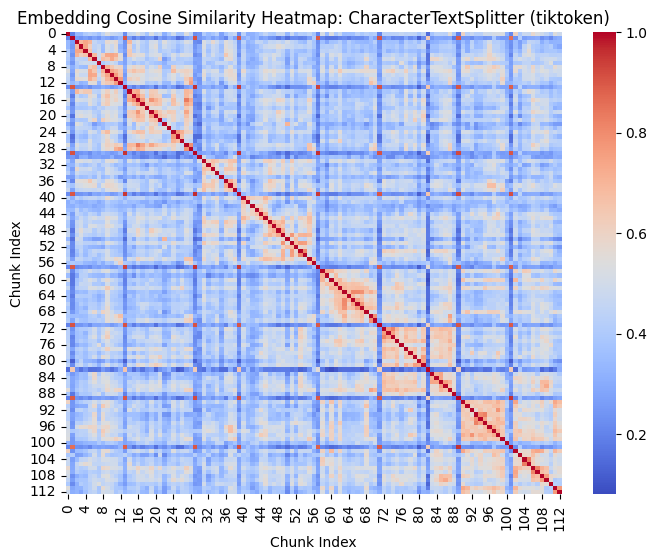

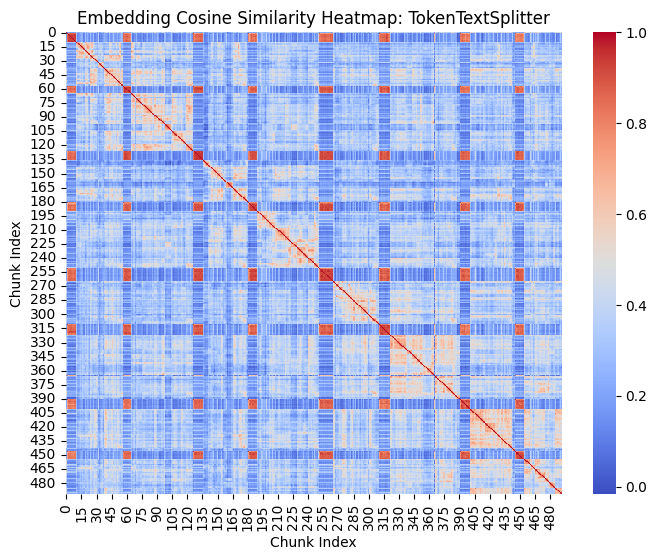

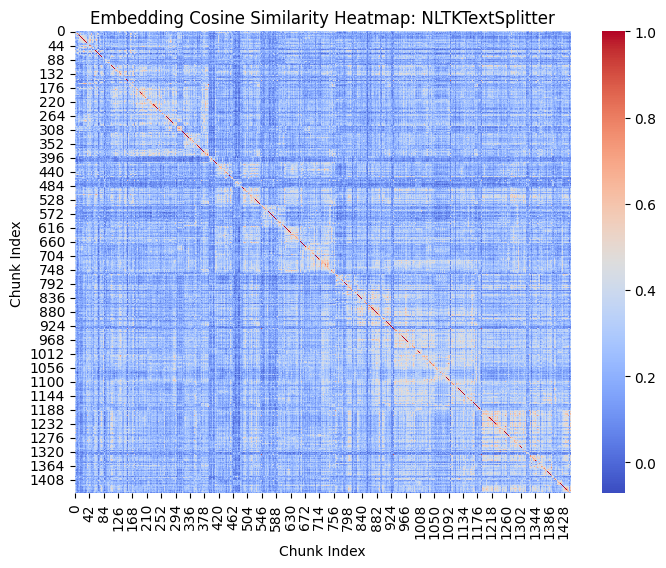

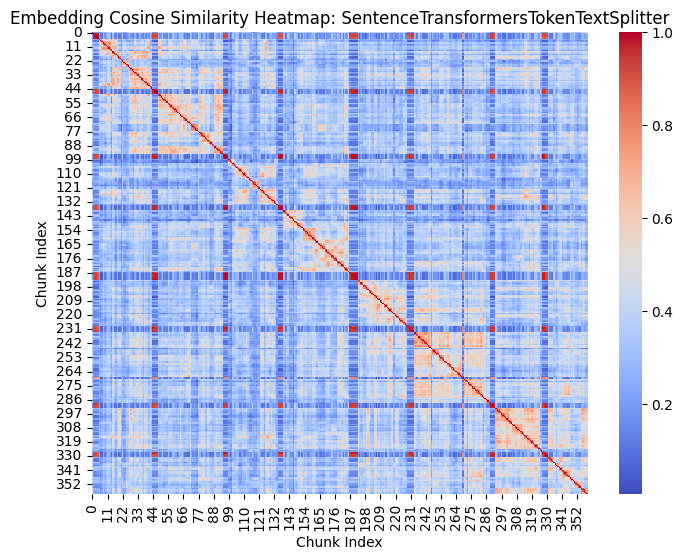

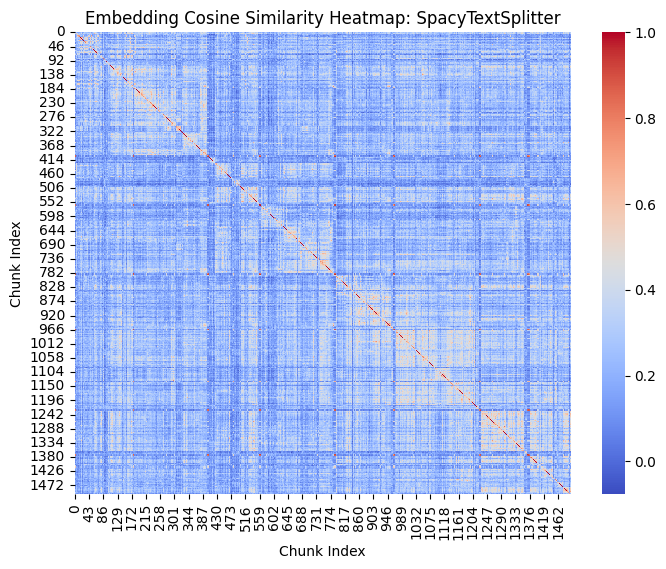

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

for splitter, emb in chunk_embeddings.items():
    sim_matrix = cosine_similarity(emb)
    plt.figure(figsize=(8,6))
    sns.heatmap(sim_matrix, cmap='coolwarm')
    plt.title(f'Embedding Cosine Similarity Heatmap: {splitter}')
    plt.xlabel('Chunk Index')
    plt.ylabel('Chunk Index')
    plt.show()

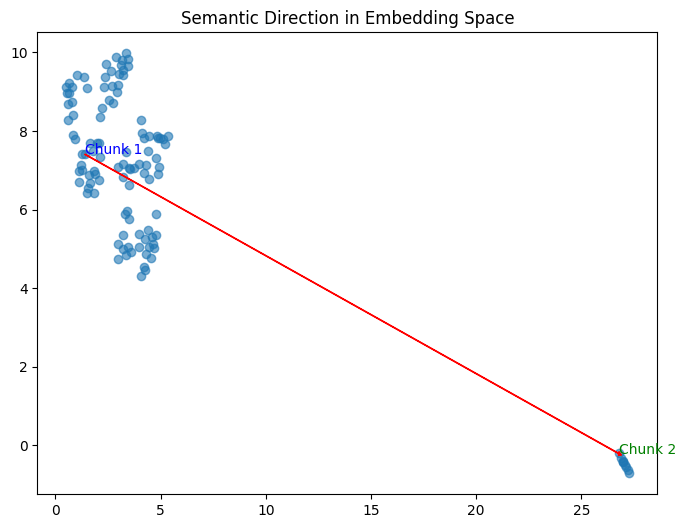

In [11]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# Pick two chunks from any splitter, e.g., science_chunk and art_chunk
splitter = list(chunk_embeddings.keys())[0]
embs = chunk_embeddings[splitter]
texts = [chunk.page_content for chunk in splitter_data[splitter]['chunks']]

# Indices for demo (replace with your own logic to pick interesting chunks)
idx1, idx2 = 0, 1
vec1, vec2 = embs[idx1], embs[idx2]
direction = np.array(vec2) - np.array(vec1)

# Project all embeddings to 2D
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embs_2d = umap_model.fit_transform(embs)

plt.figure(figsize=(8,6))
plt.scatter(embs_2d[:,0], embs_2d[:,1], alpha=0.6)
plt.arrow(embs_2d[idx1,0], embs_2d[idx1,1],
          embs_2d[idx2,0]-embs_2d[idx1,0],
          embs_2d[idx2,1]-embs_2d[idx1,1],
          color='red', width=0.01, head_width=0.1)
plt.text(embs_2d[idx1,0], embs_2d[idx1,1], "Chunk 1", color='blue')
plt.text(embs_2d[idx2,0], embs_2d[idx2,1], "Chunk 2", color='green')
plt.title("Semantic Direction in Embedding Space")
plt.show()

In [16]:
# --- Interactive Query Similarity Dashboard ---
import plotly.subplots as sp
from ipywidgets import Text, VBox, Button
import ipywidgets as widgets  # Import ipywidgets as widgets
from IPython.display import display as ipy_display
!pip install umap-learn plotly ipywidgets wordcloud matplotlib
!pip install umap-learn plotly ipywidgets
!jupyter nbextension enable --py widgetsnbextension

from google.colab import output
output.enable_custom_widget_manager()


def interactive_query_dashboard():
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    from IPython.display import clear_output

    query_input = Text(value='', description='Your Query:', placeholder='Type a word or sentence...')
    run_button = Button(description='Find Similar Chunks', button_style='success')

    output_chunks = widgets.Output()

    def on_run_clicked(b):
        output_chunks.clear_output()
        query = query_input.value.strip()
        if not query:
            with output_chunks:
                print("Please enter a query.")
            return

        # Get query embedding
        query_emb = embeddings.embed_query(query)

        # Prepare subplots for all splitters
        fig = sp.make_subplots(rows=1, cols=len(chunk_embeddings), subplot_titles=list(chunk_embeddings.keys()))
        best_chunks = {}

        for col, splitter in enumerate(chunk_embeddings.keys(), start=1):
            embs = chunk_embeddings[splitter]
            texts = [chunk.page_content for chunk in splitter_data[splitter]['chunks']]
            umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
            embs_2d = umap_model.fit_transform(embs)
            # Cosine similarity
            norm_query = np.linalg.norm(query_emb) + 1e-8
            norm_embs = np.linalg.norm(embs, axis=1) + 1e-8
            similarities = np.dot(embs, query_emb) / (norm_embs * norm_query)
            best_idx = int(np.argmax(similarities))
            best_chunks[splitter] = (best_idx, texts[best_idx])

            # Plot all chunks
            fig.add_trace(go.Scatter(
                x=embs_2d[:,0], y=embs_2d[:,1],
                mode='markers', marker=dict(size=7, color='lightgray'),
                text=["Chunk {}: {}...".format(i, texts[i][:100].replace("\n", " ")) for i in range(len(texts))],
                hoverinfo='text', name='Chunks', showlegend=False
            ), row=1, col=col)
            # Highlight best chunk
            fig.add_trace(go.Scatter(
                x=[embs_2d[best_idx,0]], y=[embs_2d[best_idx,1]],
                mode='markers+text', marker=dict(size=14, color='red'),
                text=["Best Match"], textposition='top center', name='Best', showlegend=False
            ), row=1, col=col)

        fig.update_layout(height=500, width=350*len(chunk_embeddings), title_text="Query Similarity Across Splitters")

        with output_chunks:
            fig.show()
            print("\n--- Best Matching Chunks ---")
            for splitter, (idx, text) in best_chunks.items():
                print("[{}]\nChunk {}: {}\n---".format(splitter, idx, text[:300].replace("\n", " ")))

    run_button.on_click(on_run_clicked)
    ipy_display(VBox([query_input, run_button, output_chunks])) # Use ipy_display


# Usage:

interactive_query_dashboard()

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


same above code with wordCloud for each query from each splitter Functionality added.

In [17]:


# --- Interactive Query Similarity Dashboard ---
import plotly.subplots as sp
from ipywidgets import Text, VBox, Button
!pip install umap-learn plotly ipywidgets wordcloud matplotlib
%pip install plotly ipywidgets
from google.colab import output
output.enable_custom_widget_manager()
import plotly.io as pio
pio.renderers.default = 'colab'
import ipywidgets as widgets
def interactive_query_dashboard():

    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    from IPython.display import display as ipy_display, clear_output
    query_input = Text(description="Query:", placeholder="Enter your query here")
    run_button = Button(description="Run", button_style="success")
    N = 5  # Top-N chunks for word cloud

    output_chunks = widgets.Output()
    output_wordclouds = widgets.Output()

    def on_run_clicked(b):
        output_chunks.clear_output()
        output_wordclouds.clear_output()
        query = query_input.value.strip()
        if not query:
            with output_chunks:
                print("Please enter a query.")
            return

        # Get query embedding
        query_emb = embeddings.embed_query(query)

        # Prepare subplots for all splitters
        fig = sp.make_subplots(rows=1, cols=len(chunk_embeddings), subplot_titles=list(chunk_embeddings.keys()))
        best_chunks = {}
        top_chunks_per_splitter = {}

        for col, splitter in enumerate(chunk_embeddings.keys(), start=1):
            embs = chunk_embeddings[splitter]
            texts = [chunk.page_content for chunk in splitter_data[splitter]['chunks']]
            umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
            embs_2d = umap_model.fit_transform(embs)
            # Cosine similarity
            norm_query = np.linalg.norm(query_emb) + 1e-8
            norm_embs = np.linalg.norm(embs, axis=1) + 1e-8
            similarities = np.dot(embs, query_emb) / (norm_embs * norm_query)
            best_idx = int(np.argmax(similarities))
            best_chunks[splitter] = (best_idx, texts[best_idx])

            # Top-N chunk indices
            top_indices = np.argsort(similarities)[-N:][::-1]
            top_chunks_per_splitter[splitter] = [texts[i] for i in top_indices]

            # Plot all chunks
            fig.add_trace(go.Scatter(
                x=embs_2d[:,0], y=embs_2d[:,1],
                mode='markers', marker=dict(size=7, color='lightgray'),
                text=["Chunk {}: {}...".format(i, texts[i][:100].replace("\n", " ")) for i in range(len(texts))],
                hoverinfo='text', name='Chunks', showlegend=False
            ), row=1, col=col)
            # Highlight best chunk
            fig.add_trace(go.Scatter(
                x=[embs_2d[best_idx,0]], y=[embs_2d[best_idx,1]],
                mode='markers+text', marker=dict(size=14, color='red'),
                text=["Best Match"], textposition='top center', name='Best', showlegend=False
            ), row=1, col=col)

        fig.update_layout(height=500, width=350*len(chunk_embeddings), title_text="Query Similarity Across Splitters")

        with output_chunks:
            fig.show()
            print("\n--- Best Matching Chunks ---")
            for splitter, (idx, text) in best_chunks.items():
                print("[{}]\nChunk {}: {}\n---".format(splitter, idx, text[:300].replace("\n", " ")))

        # Word Cloud Visualization for top-N chunks per splitter
        with output_wordclouds:
            clear_output(wait=True)
            fig_wc, axes_wc = plt.subplots(1, len(top_chunks_per_splitter), figsize=(5*len(top_chunks_per_splitter), 5))
            if len(top_chunks_per_splitter) == 1:
                axes_wc = [axes_wc]
            for i, (splitter, chunk_texts) in enumerate(top_chunks_per_splitter.items()):
                combined_text = " ".join(chunk_texts)
                wc = WordCloud(width=400, height=400, background_color="white").generate(combined_text)
                axes_wc[i].imshow(wc, interpolation="bilinear")
                axes_wc[i].axis("off")
                axes_wc[i].set_title(splitter, fontsize=12)
            plt.suptitle(f"Word Cloud of Top-{N} Matching Chunks per Splitter", fontsize=16)
            plt.tight_layout()
            ipy_display(fig_wc)
            plt.close(fig_wc)

    run_button.on_click(on_run_clicked)
    display(VBox([query_input, run_button, output_chunks, output_wordclouds]))

# Usage:
interactive_query_dashboard()


Now involving Vector Stores.


In [18]:
!pip install faiss-cpu langchain openai

In [19]:
from langchain.vectorstores import FAISS

faiss_stores = {}

for splitter_name, data in splitter_data.items():
    texts = [chunk.page_content for chunk in data["chunks"]]
    embeddings_np = np.array(chunk_embeddings[splitter_name]).astype("float32")
    text_embedding_pairs = list(zip(texts, embeddings_np))
    # Pass the embedding model as the second argument
    faiss_store = FAISS.from_embeddings(text_embedding_pairs, embeddings)
    faiss_stores[splitter_name] = faiss_store

In [20]:
query = str(input("Your search query here: "))
query_emb = np.array(embeddings.embed_query(query)).astype("float32").reshape(1, -1)
top_k = 3  # Number of top results to retrieve

results = {}

for splitter_name, faiss_store in faiss_stores.items():
    matches = faiss_store.similarity_search_with_score(query, k=top_k)
    results[splitter_name] = matches

for splitter, matches in results.items():
    print("\n=== {} ===".format(splitter))
    for i, (doc, score) in enumerate(matches):
        print("Top {}: (Score: {:.4f})\n{}\n---".format(i+1, score, doc.page_content[:300].replace("\n", " ")))

Your search query here: What is Democracy

=== CharacterTextSplitter (tiktoken) ===
Top 1: (Score: 0.9735)
❈   ✁ ✂ ✂ ✄ ☎ ✆ ✄ ✝ ✞ ✟ ✠ ✄ ✡ ✟ ☛ ☞ ✁ ☛ ✌ 111 ❘ ✍ ✎ ✍ ✏✑ ✒ ✑ ✒ ✓ ✎ ✍ ✔ ✕ ✖ ✗ ✘ ✖ ✙ We began this tour of  democracy last year with a minimal definition of  democracy. Do you remember that? This is what Chapter 2 of your textbook said last year: democracy is a form of  government in which the rulers 
---
Top 2: (Score: 1.0052)
90 ❉   ✁ ✂ ✄ ☎ ❛ ✆ ✝ ✄ ✞ ✂ ♦ ✝ ✆ ✝ ✄ ✟ ❍ ✠ ✡ ☛ ✠ ✡ ☞ ✌ ✍✍ ☞ ✍✍ ☛ ☞ ✎ ✠ ✏ ✑ ✌ ✏ ✒ ✓ ✍ ✠ s ✔✏ ✠ ✎ ☞ ✍ ✕ Do you remember how students in Madam Lyngdoh’s class argued about democracy? This was in Chapter 2 of Class IX textbook. It emerged from that conversation that democracy is a better form of  govern
---
Top 3: (Score: 1.0085)
❖   ✁ ✂ ✄ ☎ ✆ ✝ ✄ ✞ ✟ ✆ ☎ ✄ ✂ ✠ ✡ ✂ ☛ 97 can form a majority. Democracy remains democracy only as long as every citizen has a chance of being in majority at some point of time. If someone is barred The two images depict two different kin

In [22]:
import ipywidgets as widgets
from IPython.display import display
!pip install umap-learn plotly ipywidgets wordcloud matplotlib
!pip install umap-learn plotly ipywidgets
!jupyter nbextension enable --py widgetsnbextension

from google.colab import output
output.enable_custom_widget_manager()


def show_query_results_interactive(results):
    tabs = []
    titles = []
    for splitter, matches in results.items():
        items = []
        for i, (doc, score) in enumerate(matches):
            items.append(widgets.HTML(
                value=f"<b>Top {i+1} (Score: {score:.4f})</b><br><pre style='white-space: pre-wrap;'>{doc.page_content[:500]}</pre><hr>"
            ))
        tab_content = widgets.VBox(items)
        tabs.append(tab_content)
        titles.append(splitter)
    tab_widget = widgets.Tab(children=tabs)
    for i, title in enumerate(titles):
        tab_widget.set_title(i, title)
    display(tab_widget)

# Usage:
show_query_results_interactive(results)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [23]:
!pip install ipywidgets --quiet
!jupyter nbextension enable --py widgetsnbextension


import ipywidgets as widgets
from IPython.display import display

from google.colab import output
output.enable_custom_widget_manager()

# Ensure display is active immediately after enabling custom widget manager
display(widgets.Label("Attempting to display widget..."))


def show_query_results_interactive(results, max_height=400):
    """
    Display query results in scrollable tabs in Colab.

    Args:
        results (dict): {splitter_name: [(doc, score), ...]}
        max_height (int): Max height of each tab in pixels
    """
    tabs = []
    titles = []

    for splitter, matches in results.items():
        items = []
        for i, (doc, score) in enumerate(matches):
            content = str(getattr(doc, "page_content", doc))  # fallback if page_content missing
            items.append(widgets.HTML(
                value=f"<b>Top {i+1} (Score: {score:.4f})</b><br>"
                      f"<pre style='white-space: pre-wrap;'>{content[:1000]}</pre><hr>"
            ))

        # Wrap in scrollable box
        tab_content = widgets.VBox(items, layout=widgets.Layout(
            overflow='auto', border='1px solid gray', height=f'{max_height}px', width='100%'
        ))
        tabs.append(tab_content)
        titles.append(splitter)

    tab_widget = widgets.Tab(children=tabs)
    for i, title in enumerate(titles):
        tab_widget.set_title(i, title)

    display(tab_widget)

# Example usage:
print(results)
show_query_results_interactive(results)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Label(value='Attempting to display widget...')

{'CharacterTextSplitter (tiktoken)': [(Document(id='44e54afe-f7f4-4fa5-bc13-18e22b76c31b', metadata={}, page_content='❈\n\x00\n✁\n✂\n✂\n✄\n☎\n✆\n✄\n✝\n✞\n✟\n✠\n✄\n✡\n✟\n☛\n☞\n✁\n☛\n✌\n111\n❘ ✍ ✎ ✍ ✏✑ ✒ ✑ ✒ ✓ ✎ ✍ ✔ ✕ ✖ ✗ ✘ ✖ ✙\nWe began this tour of  democracy last year with a\nminimal definition of  democracy. Do you remember\nthat? This is what Chapter 2 of your textbook said last\nyear: democracy is a form of  government in which\nthe rulers are elected by the people. We then looked at\nmany cases and expanded the definition slightly to add\nsome qualifications:\n✚ the rulers elected by the people must take all the\nmajor decisions;\n✚ elections must offer a choice and fair opportunity\nto the people to change the current rulers;\n✚ this choice and opportunity should be available to\nall the people on an equal basis; and\n✚ the exercise of this choice must lead to a\ngovernment limited by basic rules of the constitution\nand citizens’ rights.\nYou may have felt disappointed that the 